In [16]:
using AutoRisk
using AutomotiveDrivingModels
using AutoViz
using Interact

In [17]:
function simulate!(scene::Scene, models::Dict{Int, DriverModel},
        roadway::Roadway, rec::SceneRecord, T::Float64)
    actions = Array(DriveAction, length(scene))
    # simulate for T seconds in rec.timestep-length substeps
    for t in 0:rec.timestep:(T - rec.timestep)
        get_actions!(actions, scene, roadway, models)
        tick!(scene, roadway, actions, models)
        AutomotiveDrivingModels.update!(rec, scene)
    end
    return rec
end

simulate! (generic function with 1 method)

In [18]:
export MY_MOBIL

"""
    MY_MOBIL
See Treiber & Kesting, 'Modeling Lane-Changing Decisions with MY_MOBIL'
"""
type MY_MOBIL <: LaneChangeModel{LaneChangeChoice}

    dir::Int
    rec::SceneRecord
    mlon::LongitudinalDriverModel
    safe_decel::Float64 # safe deceleration (positive value)
    politeness::Float64 # politeness factor (suggested p ∈ [0.2,0.5])
    advantage_threshold::Float64 # Δaₜₕ

    function MY_MOBIL(
        action_context::IntegratedContinuous;
        rec::SceneRecord=SceneRecord(2,action_context.Δt),
        mlon::LongitudinalDriverModel=IntelligentDriverModel(),
        safe_decel::Float64=2.0, # [m/s²]
        politeness::Float64=0.35,
        advantage_threshold::Float64=0.1,
        )
        retval = new()
        retval.dir = DIR_MIDDLE
        retval.rec = rec
        retval.mlon = mlon
        retval.safe_decel = safe_decel
        retval.politeness = politeness
        retval.advantage_threshold = advantage_threshold
        retval
    end
end
get_name(::MY_MOBIL) = "MY_MOBIL"
function set_desired_speed!(model::MY_MOBIL, v_des::Float64)
    set_desired_speed!(model.mlon, v_des)
    model
end
function AutomotiveDrivingModels.observe!(model::MY_MOBIL, scene::Scene, roadway::Roadway, egoid::Int)
    rec = model.rec
    AutomotiveDrivingModels.update!(rec, scene)

    vehicle_index = get_index_of_first_vehicle_with_id(rec, egoid)
    veh_ego = scene[vehicle_index]
    v = veh_ego.state.v
    egostate_M = veh_ego.state

    left_lane_exists = convert(Float64, get(N_LANE_LEFT, rec, roadway, vehicle_index)) > 0
    right_lane_exists = convert(Float64, get(N_LANE_RIGHT, rec, roadway, vehicle_index)) > 0
    fore_M = get_neighbor_fore_along_lane(scene, vehicle_index, roadway, VehicleTargetPointFront(), VehicleTargetPointRear(), VehicleTargetPointFront())
    rear_M = get_neighbor_rear_along_lane(scene, vehicle_index, roadway, VehicleTargetPointFront(), VehicleTargetPointFront(), VehicleTargetPointRear())

    # accel if we do not make a lane change
    accel_M_orig = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, egoid))
    model.dir = DIR_MIDDLE

    advantage_threshold = model.advantage_threshold
    if right_lane_exists

        rear_R = get_neighbor_rear_along_right_lane(scene, vehicle_index, roadway, VehicleTargetPointFront(), VehicleTargetPointFront(), VehicleTargetPointRear())
        
        # candidate position after lane change is over
        footpoint = get_footpoint(veh_ego)
        lane = roadway[veh_ego.state.posF.roadind.tag]
        lane_R = roadway[LaneTag(lane.tag.segment, lane.tag.lane - 1)]
        roadproj = proj(footpoint, lane_R, roadway)
        frenet_R = Frenet(RoadIndex(roadproj), roadway)
        egostate_R = VehicleState(frenet_R, roadway, veh_ego.state.v)

        Δaccel_n = 0.0
        passes_safety_criterion = true
        if rear_R.ind != 0
            id = scene[rear_R.ind].def.id
            accel_n_orig = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))
            veh_ego.state = egostate_R
            accel_n_test = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))

            body = inertial2body(get_rear_center(scene[rear_R.ind]), get_front_center(veh_ego)) # project target to be relative to ego
            s_gap = body.x

            veh_ego.state = egostate_M
            passes_safety_criterion = accel_n_test ≥ -model.safe_decel && s_gap ≥ 0
            Δaccel_n = accel_n_test - accel_n_orig
        end

        if passes_safety_criterion

            Δaccel_o = 0.0
            if rear_M.ind != 0
                id = scene[rear_M.ind].def.id
                accel_o_orig = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))
                veh_ego.state = egostate_R
                accel_o_test = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))
                veh_ego.state = egostate_M
                Δaccel_o = accel_o_test - accel_o_orig
            end

            veh_ego.state = egostate_R
            accel_M_test = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, egoid))
            veh_ego.state = egostate_M
            Δaccel_M = accel_M_test - accel_M_orig

            Δaₜₕ = Δaccel_M + model.politeness*(Δaccel_n + Δaccel_o)
            if Δaₜₕ > advantage_threshold
                model.dir = DIR_RIGHT
                advantage_threshold = Δaₜₕ
            end
        end
    end

    if left_lane_exists
        rear_L = get_neighbor_rear_along_left_lane(scene, vehicle_index, roadway, VehicleTargetPointFront(), VehicleTargetPointFront(), VehicleTargetPointRear())
        
        # candidate position after lane change is over
        footpoint = get_footpoint(veh_ego)
        lane = roadway[veh_ego.state.posF.roadind.tag]
        lane_L = roadway[LaneTag(lane.tag.segment, lane.tag.lane + 1)]
        roadproj = proj(footpoint, lane_L, roadway)
        frenet_L = Frenet(RoadIndex(roadproj), roadway)
        egostate_L = VehicleState(frenet_L, roadway, veh_ego.state.v)

        Δaccel_n = 0.0
        passes_safety_criterion = true
        if rear_L.ind != 0
            id = scene[rear_L.ind].def.id
            accel_n_orig = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))
            veh_ego.state = egostate_L
            accel_n_test = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))

            body = inertial2body(get_rear_center(scene[rear_L.ind]), get_front_center(veh_ego)) # project target to be relative to ego
            s_gap = body.x

            veh_ego.state = egostate_M
            passes_safety_criterion = accel_n_test ≥ -model.safe_decel && s_gap ≥ 0
            Δaccel_n = accel_n_test - accel_n_orig
        end

        if passes_safety_criterion


            Δaccel_o = 0.0
            if rear_M.ind != 0
                id = scene[rear_M.ind].def.id
                accel_o_orig = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))
                veh_ego.state = egostate_L
                accel_o_test = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, id))
                veh_ego.state = egostate_M
                Δaccel_o = accel_o_test - accel_o_orig
            end

            veh_ego.state = egostate_L
            accel_M_test = rand(observe!(reset_hidden_state!(model.mlon), scene, roadway, egoid))
            veh_ego.state = egostate_M
            Δaccel_M = accel_M_test - accel_M_orig

            Δaₜₕ = Δaccel_M + model.politeness*(Δaccel_n + Δaccel_o)
            if Δaₜₕ > advantage_threshold
                model.dir = DIR_LEFT
                advantage_threshold = Δaₜₕ
            end
        end
    end

    model
end
Base.rand(model::MY_MOBIL) = LaneChangeChoice(model.dir)

In [19]:
# simultaneous lane change eval
context = IntegratedContinuous(.1, 1)
num_veh = 4
roadway = gen_stadium_roadway(3, length = 400.0, radius = 100.0)

# build the scene
scene = Scene(num_veh)
road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
road_pos = 20.
base_speed = 10.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(1, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
road_pos = 10.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(2, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_idx = RoadIndex(proj(VecSE2(0.0, -6.0, 0.0), roadway))
road_pos = 10.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(3, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_idx = RoadIndex(proj(VecSE2(0.0, -6.0, 0.0), roadway))
road_pos = 20.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(4, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

rec = SceneRecord(500, .1, num_veh)
T = 5.

# simulate the scene with 0 second time delay idm and compare with normal
# 0 second delay simulation
models = Dict{Int, DriverModel}()
models[1] = Tim2DDriver(context, mlane=MY_MOBIL(context, politeness=.7))
models[2] = Tim2DDriver(context, mlane=MY_MOBIL(context, politeness=.7))
models[3] = Tim2DDriver(context, mlane=MY_MOBIL(context, politeness=.7))
models[4] = Tim2DDriver(context, mlane=MY_MOBIL(context, politeness=.7))
simulate!(scene, models, roadway, rec, T)

SceneRecord(nscenes=50)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(24, nactions=1),"i",24,"24",Interact.OptionDict(DataStructures.OrderedDict("0"=>0,"1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",42=>"42",29=>"29",8=>"8",20=>"20",14=>"14"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(2.0, nactions=1),"zoom",2.0,"2.0",Interact.OptionDict(DataStructures.OrderedDict("2.0"=>2.0,"4.0"=>4.0,"6.0"=>6.0,"8.0"=>8.0,"10.0"=>10.0,"12.0"=>12.0,"14.0"=>14.0,"16.0"=>16.0,"18.0"=>18.0,"20.0"=>20.0…),Dict(18.0=>"18.0",4.0=>"4.0",14.0=>"14.0",10.0=>"10.0",20.0=>"20.0",2.0=>"2.0",16.0=>"16.0",8.0=>"8.0",6.0=>"6.0",12.0=>"12.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"veh_id",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4),Dict(4=>"4",2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

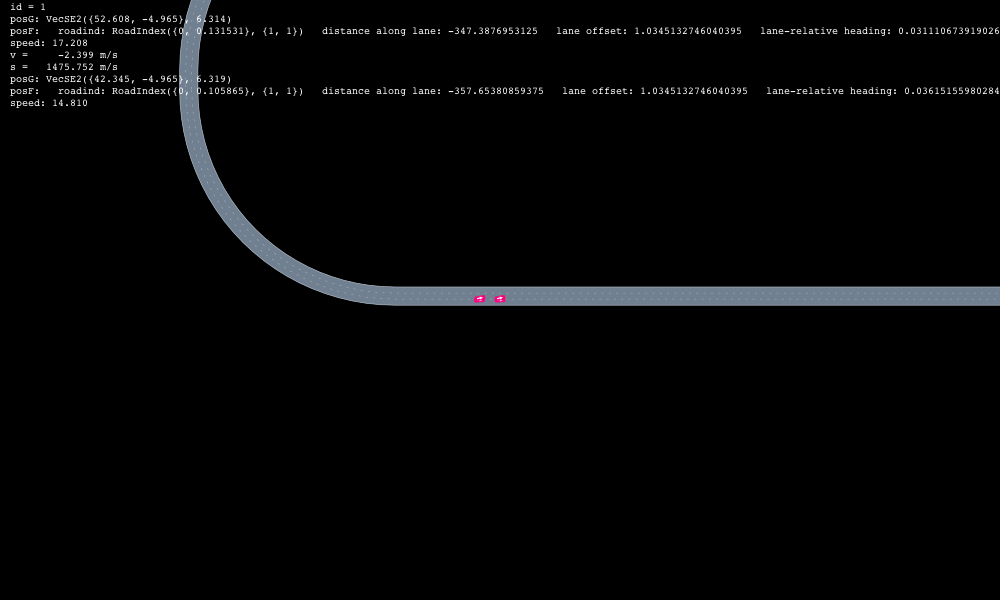

In [6]:
scene = Scene()
@manipulate for i in 0:(rec.nscenes - 1),
        zoom in collect(2:2:20.),
        veh_id in collect(1:4)
    render(get_scene(rec, -(rec.nscenes - i)), roadway, [CarFollowingStatsOverlay(veh_id, 2)], cam=CarFollowCamera(veh_id, zoom))
end

In [20]:
type MY_DelayedIntelligentDriverModel <: LongitudinalDriverModel
    a::Float64 # predicted acceleration
    σ::Float64 # optional stdev on top of the model, set to zero or NaN for deterministic behavior

    k_spd::Float64 # proportional constant for speed tracking when in freeflow [s⁻¹]

    δ::Float64 # acceleration exponent [-]
    T::Float64 # desired time headway [s]
    v_des::Float64 # desired speed [m/s]
    s_min::Float64 # minimum acceptable gap [m]
    a_max::Float64 # maximum acceleration ability [m/s²]
    d_cmf::Float64 # comfortable deceleration [m/s²] (positive)
    d_max::Float64 # maximum decelleration [m/s²] (positive)

    t_d::Float64 # reaction time (time delay in responding) [s]
    buf::CircularBuffer{Tuple{Float64, Float64}} # state buffer
    _print::Bool
 
    function MY_DelayedIntelligentDriverModel(Δt;
        σ::Float64     =   NaN,
        k_spd::Float64 =   1.0,
        δ::Float64     =   4.0,
        T::Float64     =   1.5,
        v_des::Float64 =  29.0, # typically overwritten
        s_min::Float64 =   5.0,
        a_max::Float64 =   3.0,
        d_cmf::Float64 =   2.0,
        d_max::Float64 =   9.0,
        t_d::Float64   =   0.0,
        _print::Bool   =   false)

        retval = new()
        retval.a = NaN
        retval.k_spd = k_spd
        retval.δ     = δ
        retval.T     = T
        retval.v_des = v_des
        retval.s_min = s_min
        retval.a_max = a_max
        retval.d_cmf = d_cmf
        retval.d_max = d_max
        retval._print = _print

        # delayed reaction members
        retval.t_d = t_d
        # buffer holds states from previous timesteps
        # where state = (s_gap, lead_velocity)
        buf_size = Int(ceil(t_d / Δt)) + 1
        buf = CircularBuffer{Tuple{Float64, Float64}}(buf_size)

        # start the buffer filled with states that will cause the vehicle to 
        # act as though it does not have a lead vehicle
        append!(buf, fill!(Vector{Tuple{Float64,Float64}}(buf_size), (-Inf, 0)))
        retval.buf = buf

        retval
    end
end

get_name(::MY_DelayedIntelligentDriverModel) = "Delayed_IDM"

function AutomotiveDrivingModels.set_desired_speed!(model::MY_DelayedIntelligentDriverModel, 
        v_des::Float64)
    model.v_des = v_des
    model
end

function AutomotiveDrivingModels.track_longitudinal!(model::MY_DelayedIntelligentDriverModel, 
        scene::Scene, roadway::Roadway, ego_index::Int, target_index::Int)
    
    # get the ego vehicle and its velocity
    veh_ego = scene[ego_index]
    v = veh_ego.state.v

    # first add samples to the buffer so that t_d = 0 gives the current sample
    # if the target exists at the current timestep, then add its state to the buffer
    if target_index > 0
        veh_target = scene[target_index]
        s_gap = get_frenet_relative_position(get_rear_center(veh_target),
                                            veh_ego.state.posF.roadind, roadway).Δs
        push!(model.buf, (s_gap, veh_target.state.v))

    # if a target is not found, then add (s_gap, lead_velocity) value s.t. 
    # driver behaves as though no vehicle is in front (i.e., s_gap = -Inf)
    else
        push!(model.buf, (-Inf, 0))
    end

    # regardless of whether a target vehicle _currently_ exists, act according
    # to the stored state in the buffer
    s_gap, lead_v = model.buf[1]

    # s_gap > 0.0, then execute IDM model
    if s_gap > 0.0
        Δv = lead_v - v
        s_des = model.s_min + v*model.T - v*Δv / (2*sqrt(model.a_max*model.d_cmf))
        v_ratio = model.v_des > 0.0 ? (v/model.v_des) : 1.0
        model.a = model.a_max * (1.0 - v_ratio^model.δ - (s_des / s_gap)^2)
    
    # if collision imminent, apply maximum decel 
    elseif s_gap > -veh_ego.def.length 
        if model._print
            println("maximum decel applied with s_gap: $(s_gap)\t veh len: $(-veh_ego.def.length)")
        end
        model.a = -model.d_max

    # otherwise, drive to match desired velocity
    else
        if model._print
            println("driving normally s_gap: $(s_gap)")
        end
        Δv = model.v_des - v
        model.a = Δv*model.k_spd
    end
    
    # if velocity is negative, then prevent negative acceleration, otherwise clamp to max decel
    low = v < 0. ? 0. : -model.d_max
    model.a = clamp(model.a, low, model.a_max)
    model
end

function AutomotiveDrivingModels.observe!(model::MY_DelayedIntelligentDriverModel, 
        scene::Scene, roadway::Roadway, egoid::Int)    
    # update the predicted accel
    vehicle_index = get_index_of_first_vehicle_with_id(scene, egoid)
    veh_ego = scene[vehicle_index]
    fore_res = get_neighbor_fore_along_lane(scene, vehicle_index, roadway, VehicleTargetPointFront(), VehicleTargetPointRear(), VehicleTargetPointFront())

    track_longitudinal!(model, scene, roadway, vehicle_index, fore_res.ind)
    model
end

function Base.rand(model::MY_DelayedIntelligentDriverModel)
    if isnan(model.σ) || model.σ ≤ 0.0
        model.a
    else
        rand(Normal(model.a, model.σ))
    end
end

function Distributions.pdf(model::MY_DelayedIntelligentDriverModel, a_lon::Float64)
    if isnan(model.σ) || model.σ ≤ 0.0
        Inf
    else
        pdf(Normal(model.a, model.σ), a_lon)
    end
end

function Distributions.logpdf(model::MY_DelayedIntelligentDriverModel, a_lon::Float64)
    if isnan(model.σ) || model.σ ≤ 0.0
        Inf
    else
        logpdf(Normal(model.a, model.σ), a_lon)
    end
end

In [7]:
# collision eval
srand(1)

context = IntegratedContinuous(.1, 1)
num_veh = 20
roadway = gen_stadium_roadway(3, length = 400.0, radius = 100.0)

# build the scene
scene = Scene(num_veh)
for veh_id in 1:num_veh
    road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
    road_pos = rand() * 10
    veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
    veh_state = move_along(veh_state, roadway, road_pos)
    veh_def = VehicleDef(veh_id, AgentClass.CAR, 5., 2.)
    push!(scene, Vehicle(veh_state, veh_def))
end

models = Dict{Int, DriverModel}()
for veh_id in 1:num_veh
#     mlon = DelayedIntelligentDriverModel(context.Δt, t_d = .0)
#     _print = veh_id == 2 ? true : false
    _print = false
    mlon = MY_DelayedIntelligentDriverModel(context.Δt, t_d = .0, _print = _print)
    mlon.σ = 1.
    mlane = MY_MOBIL(context, politeness=.7)
    mlat = ProportionalLaneTracker()
    mlat.σ = .2
    models[veh_id] = Tim2DDriver(context, mlane=mlane, mlon=mlon, mlat=mlat)
end

rec = SceneRecord(500, .1, num_veh)
T = 50.
simulate!(scene, models, roadway, rec, T)

SceneRecord(nscenes=500)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(249, nactions=1),"i",249,"249",Interact.OptionDict(DataStructures.OrderedDict("0"=>0,"1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9…),Dict(288=>"288",306=>"306",11=>"11",491=>"491",134=>"134",158=>"158",160=>"160",215=>"215",464=>"464",29=>"29"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"3.0"=>3.0,"5.0"=>5.0,"7.0"=>7.0,"9.0"=>9.0,"11.0"=>11.0,"13.0"=>13.0,"15.0"=>15.0,"17.0"=>17.0,"19.0"=>19.0…),Dict(7.0=>"7.0",9.0=>"9.0",13.0=>"13.0",3.0=>"3.0",19.0=>"19.0",17.0=>"17.0",11.0=>"11.0",5.0=>"5.0",15.0=>"15.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"veh_id",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(18=>"18",2=>"2",16=>"16",11=>"11",7=>"7",9=>"9",10=>"10",19=>"19",17=>"17",8=>"8"…)),Any[],Any[],true,"horizontal")

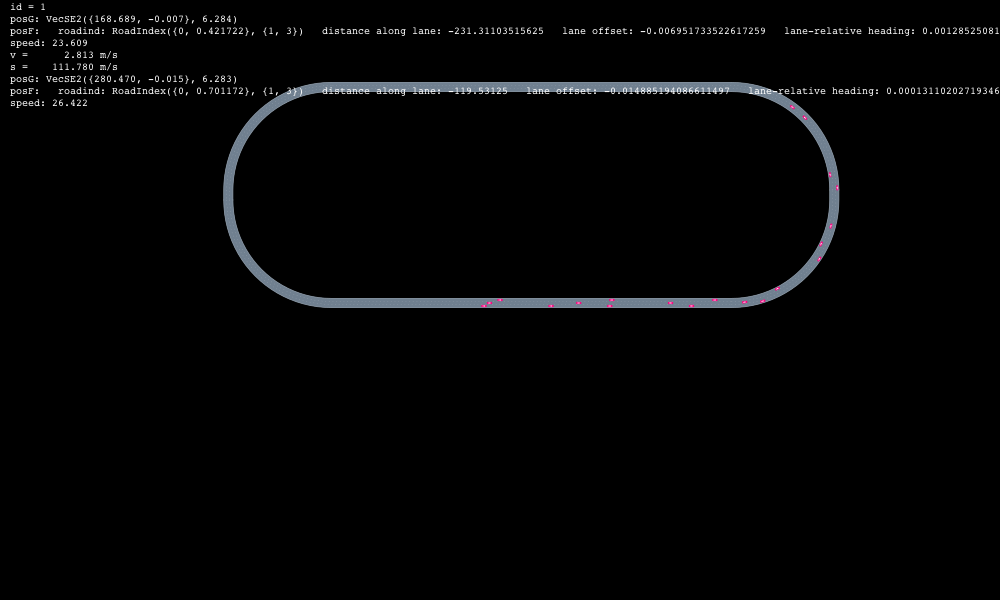

Failed to push!
    0
to node
    ::Int64) at /Users/wulfebw/.julia/v0.5/AutomotiveDrivingModels/src/core/scene_records.jl:28
 in (::Reactive.##16#17{##27#28,Tuple{Reactive.Signal{Int64},Reactive.Signal{Float64},Reactive.Signal{Int64}}})(::Reactive.Signal{Any}, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/operators.jl:39
 in do_action(::Reactive.Action, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:135
 in send_value!(::Reactive.Signal{Int64}, ::Int64, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:130
 in send_value!(::WeakRef, ::Int64, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:133
 in run(::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:215
 in run() at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:235
 in macro expansion at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:263 [inlined]
 in (::Reactive.##12#14)() at ./task.jl:360


In [8]:
scene = Scene()
@manipulate for i in 0:(rec.nscenes - 1),
        zoom in collect(1:2:20.),
    veh_id in collect(1:num_veh)
    render(get_scene(rec, -(rec.nscenes - i)), roadway, [CarFollowingStatsOverlay(veh_id, 2)], cam=CarFollowCamera(veh_id, zoom))
end

In [44]:
# exit curve eval
srand(1)

context = IntegratedContinuous(.1, 1)
num_veh = 4
num_lanes = 2
roadway = gen_stadium_roadway(num_lanes, length = 400.0, radius = 100.0)

# build the scene

# build the scene
scene = Scene(num_veh)
road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
road_pos = -30.
base_speed = 10.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(1, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
road_pos = -100.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(2, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_idx = RoadIndex(proj(VecSE2(0.0, -2.9, 0.0), roadway))
road_pos = 0.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(3, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_idx = RoadIndex(proj(VecSE2(0.0, -2.9, 0.0), roadway))
road_pos = -20.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(4, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

for veh_id in 1:num_veh
    mlon = MY_DelayedIntelligentDriverModel(context.Δt, t_d = .0)
    mlon.σ = .5
    mlane = MY_MOBIL(context, politeness=.7)
    mlat = ProportionalLaneTracker()
    mlat.σ = .1
    models[veh_id] = Tim2DDriver(context, mlane=mlane, mlon=mlon, mlat=mlat)
end



rec = SceneRecord(500, .1, num_veh)
T = 50.
simulate!(scene, models, roadway, rec, T)

SceneRecord(nscenes=500)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(249, nactions=1),"i",249,"249",Interact.OptionDict(DataStructures.OrderedDict("0"=>0,"1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9…),Dict(288=>"288",306=>"306",11=>"11",491=>"491",134=>"134",158=>"158",160=>"160",215=>"215",464=>"464",29=>"29"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"3.0"=>3.0,"5.0"=>5.0,"7.0"=>7.0,"9.0"=>9.0,"11.0"=>11.0,"13.0"=>13.0,"15.0"=>15.0,"17.0"=>17.0,"19.0"=>19.0…),Dict(7.0=>"7.0",9.0=>"9.0",13.0=>"13.0",3.0=>"3.0",19.0=>"19.0",17.0=>"17.0",11.0=>"11.0",5.0=>"5.0",15.0=>"15.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"veh_id",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4),Dict(4=>"4",2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

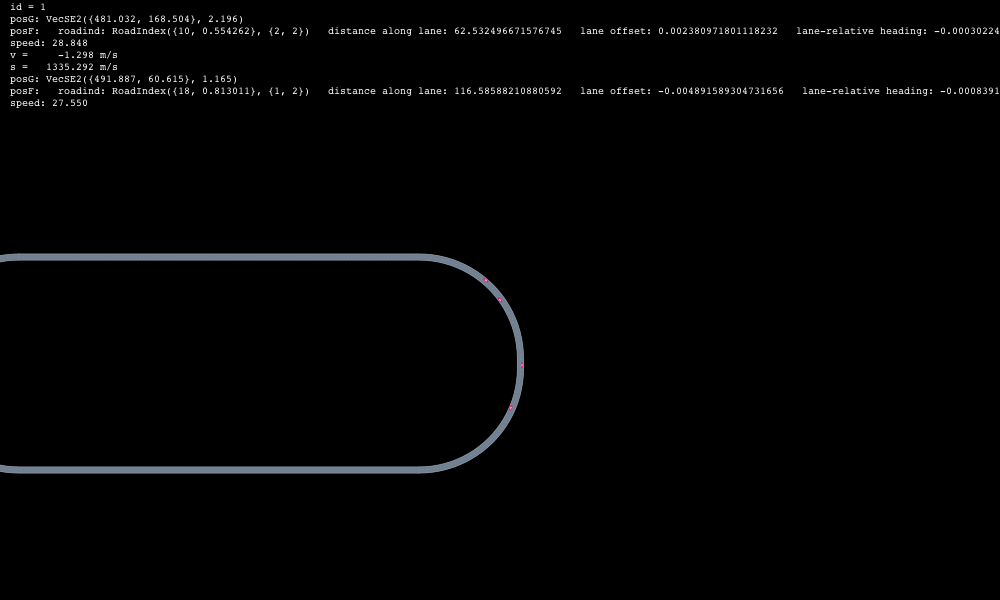

Failed to push!
    0
to node
    WeakRef(Signal{Int64}(0, nactions=2))
BoundsError: attempt to access 500-element Array{AutomotiveDrivingModels.AutoCore.Scene,1} at index [501]
 in get_scene(::AutomotiveDrivingModels.AutoCore.SceneRecord, ::Int64) at /Users/wulfebw/.julia/v0.5/AutomotiveDrivingModels/src/core/scene_records.jl:28
 in (::Reactive.##16#17{##55#56,Tuple{Reactive.Signal{Int64},Reactive.Signal{Float64},Reactive.Signal{Int64}}})(::Reactive.Signal{Any}, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/operators.jl:39
 in do_action(::Reactive.Action, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:135
 in send_value!(::Reactive.Signal{Int64}, ::Int64, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:130
 in send_value!(::WeakRef, ::Int64, ::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:133
 in run(::Int64) at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:215
 in run() at /Users/wulfebw/.julia/v0.5/Reactive/src/core.jl:235
 in macro expan

In [45]:
scene = Scene()
@manipulate for i in 0:(rec.nscenes - 1),
        zoom in collect(1:2:20.),
    veh_id in collect(1:num_veh)
    render(get_scene(rec, -(rec.nscenes - i)), roadway, [CarFollowingStatsOverlay(veh_id, 2)], cam=CarFollowCamera(veh_id, zoom))
end